# CE811 Tabular Q-learning Example

M. Fairbank, University of Essex, December 2021

- In this lab we use a table of learnable Q-values with the Q-learning algorithm to solve a maze.

- The environment gives a reward of -1 every time step, so to maximise reward, the agent must learn to finish the maze as fast as possible.

- Q-learning is an on-line algorithm, so the agent can solve the maze on its very first attempt (if we wait long enough)

Acknowledgements:  This Q-learning and maze environment is based on one initially built by M. Pisheh (University of Essex)


## First build a maze environment:
- The maze is simply a numpy array.  0s represent walkable areas.  1s represent solid walls.
- The environment_step function is the function that executes an agent's action (i.e north/south/east/west) 
- It calculates the new state (y,x) and the instantaneous reward (-1 each step).
- Note that throughout this notebook, states are y,x not x,y!

In [23]:
import random
import numpy as np

maze=np.array([
        [1,1,1,1,1,1,1,1,1],
        [1,0,1,0,0,0,0,0,1],
        [1,0,1,1,1,0,1,0,1],
        [1,0,0,0,1,0,1,0,1],
        [1,1,1,0,1,0,1,0,1],
        [1,0,0,0,1,0,1,0,1],
        [1,0,1,1,1,0,1,1,1],
        [1,0,1,0,0,0,0,0,1],
        [1,0,1,1,1,1,1,0,1],
        [1,0,0,0,0,0,0,0,1],
        [1,1,1,1,1,1,1,0,1],
        [1,0,0,0,0,0,1,0,1],
        [1,0,1,0,1,1,1,0,1],
        [1,0,1,0,0,0,1,0,1],
        [1,0,1,1,1,0,1,0,1],
        [1,0,0,0,1,0,0,0,1],
        [1,1,1,1,1,1,1,1,1]])

maze_width=maze.shape[1]
maze_height=maze.shape[0]
start_state = [1,1] # top left corner zero
goal_state = [maze_height-2,maze_width-2] # bottom-right corner zero

action_names=["North","South","West","East"]
action_effects=[[-1,0],[1,0],[0,-1],[0,1]]

def environment_step(action,state):
    y,x = state
    dy,dx=action_effects[action]
    new_x = x+dx
    new_y = y+dy
    if new_x <0 or new_x>=maze_width:
        # off grid
        new_x = x
    if new_y <0 or new_y>=maze_height:
        # off grid
        new_y = y
    if maze[new_y,new_x] == 1:
        # hit wall
        new_y=y
        new_x=x
    new_state = [new_y,new_x]
    reward = -1
    done = (new_state==goal_state)
    return new_state, reward, done

print("maze",maze)
print("start",start_state)
print("goal",goal_state)

maze [[1 1 1 1 1 1 1 1 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 1]
 [1 0 1 1 1 0 1 1 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 1]
 [1 0 1 0 1 1 1 0 1]
 [1 0 1 0 0 0 1 0 1]
 [1 0 1 1 1 0 1 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 1 1 1 1 1 1 1 1]]
start [1, 1]
goal [15, 7]


## Next build our table of Q-values. 
- There are 4 potential actions from each maze cell, therefore we need 4 Q-values for each maze cell, i.e. a numpy array of shape [maze_height, maze_width, 4]

In [24]:
# Create our table of Q-values.  We need 4 q-values for every cell in the maze.
Qtable = np.zeros((maze_height, maze_width, 4), dtype=np.float64)
print(Qtable.shape)

(17, 9, 4)


## Next define a policy function
- This is the epsilon greedy policy.
- Remember, Q-learning has 2 policies
- This policy (the epsilon-greedy policy) is the policy the agent will follow.
- <span style="color:red">TODO: modify the code below to the epsilon-greedy policy</span>.

In [25]:
def run_policy(current_state, epsilon):
    # This function runs the epsilon-greedy policy to choose the integer action to take (i.e. 0,1,2 or 3)
    # TODO modify this function to be the epsilon greedy policy.
    # With probability epsilon, it should return a purely random action.
    if np.random.random() < epsilon:
        return np.random.choice([0,1,2,3])
    # Greedy policy
    y,x=current_state
    q_values=Qtable[y,x,:]
    best_q_value=q_values.max()
    best_q_indices=np.argwhere(q_values == best_q_value).flatten().tolist()
    #if multiple q values have the maximum value, then choose one of them randomly
    choice = np.random.choice(best_q_indices)

    return choice

## Next Define the Q-learning update (learning step)
- Remember for Q-learning, the update is $\Delta Q_t=\eta (Q'_t - Q_t)$ where
$$Q_t=Qtable[s_t,a_t]$$ and
$$Q'_t=\begin{cases}r_t + \gamma \max_{a}Q(s_{t+1},a)&\text{if }s_{t+1}\notin \mathbb{T}\\r_t&\text{if }s_{t+1} \in \mathbb{T}\end{cases}$$
- Note in the function arguments below:
  - state is $s_t$
  - action is $a_t$
  - reward is $r_t$
  - next_state is $s_{t+1}$
  - done is True iff $s_{t+1} \in \mathbb{T}$
  - discount_factor is $\gamma$
- Also note that each state $s_t$ and $s_{t+1}$ can be decomposed into $(y,x)$.  It's NOT $(x,y)$.
- <span style="color:red">TODO: modify the code below to apply the q-learning update...</span>.

In [26]:
def apply_q_update(state, action, reward, next_state, done, discount_factor):
    sy,sx=state
    nsy,nsx=next_state
    current_q_value = Qtable[sy,sx,action]
    all_q_values_at_next_state=Qtable[nsy,nsx, :]
    # TODO set the variable target_q_value here....
    if done:
        target_q_value = reward
    else:
        # Hint use "all_q_values_at_next_state" and "np.max" in this next line.
        target_q_value = reward + discount_factor * np.max(all_q_values_at_next_state)
    Qtable[sy,sx,action] += learning_rate * (target_q_value- current_q_value) #update
    return current_q_value, state

## Define the main trajectory unroll loop, and learning algorithm:

In [27]:
iterations = 1000
learning_rate = 0.1
epsilon_greedy = 0.1
discount_factor=1

reward_history=[]
trajectory_length_history=[]
for iteration in range(iterations):
    state=start_state
    total_reward=0
    done=False
    time_step=0
    while not done:
        # Choose an action
        action = run_policy(state, epsilon_greedy)
        #print("time_step",time_step,"state",state,"action",action)
        next_state, reward, done = environment_step(action, state)
        #print("action",action, "next_state", next_state, "reward",reward, "done", done)
        
        apply_q_update(state, action, reward, next_state,  done, discount_factor)

        state = next_state
        total_reward += reward*(discount_factor**time_step)
        time_step+=1
        if time_step>50000:
            raise Exception("Should have solved it by now - something is wrong with the code")
    print("Iteration",iteration,"Done.  Total_reward=",total_reward, "Trajectory length",time_step)
    reward_history.append(total_reward)
    trajectory_length_history.append(time_step)

Iteration 0 Done.  Total_reward= -453 Trajectory length 453
Iteration 1 Done.  Total_reward= -778 Trajectory length 778
Iteration 2 Done.  Total_reward= -718 Trajectory length 718
Iteration 3 Done.  Total_reward= -560 Trajectory length 560
Iteration 4 Done.  Total_reward= -480 Trajectory length 480
Iteration 5 Done.  Total_reward= -461 Trajectory length 461
Iteration 6 Done.  Total_reward= -584 Trajectory length 584
Iteration 7 Done.  Total_reward= -313 Trajectory length 313
Iteration 8 Done.  Total_reward= -225 Trajectory length 225
Iteration 9 Done.  Total_reward= -382 Trajectory length 382
Iteration 10 Done.  Total_reward= -247 Trajectory length 247
Iteration 11 Done.  Total_reward= -398 Trajectory length 398
Iteration 12 Done.  Total_reward= -290 Trajectory length 290
Iteration 13 Done.  Total_reward= -187 Trajectory length 187
Iteration 14 Done.  Total_reward= -439 Trajectory length 439
Iteration 15 Done.  Total_reward= -185 Trajectory length 185
Iteration 16 Done.  Total_reward= 

## Plot graphs
- Should show performance improving over time....
- This maze is theoretically solvable in 24 steps

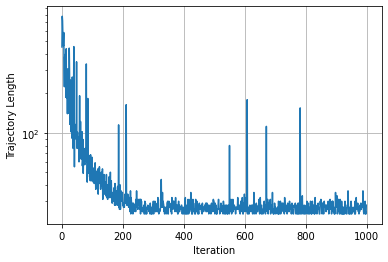

In [28]:
import matplotlib.pyplot as plt
plt.plot(trajectory_length_history)
plt.ylabel('Trajectory Length')
plt.yscale('log')
plt.xlabel('Iteration')
plt.grid()
plt.show()

## Further improvements?

- We could use a decaying epsilon greedy policy to make the trajectory length converge to the optimal length.
- If you experiment with setting epsilon to zero then it sometimes still works really well.  This is very unusual.
It must because the default Q-values of zero are higher than the final Q-values (which are all negative)
therefore exploration is encouraged towards rarely-visited locations.  But have a think about this.
- A GUI showing the agent in the maze would be nice, but animations will slow down learning.
